# **Lab 2.2: Bird’s-Eye-View (BEV) Transformation**

In this lab, you will learn how to transform the lane mask from the camera view to the **bird’s-eye view (BEV)**.  
This step helps normalize lane geometry measurements.  
You will use the mask refined from Lab 2.1 as the input.


### **Task 1 – Import libraries**
>In this step, you need to initialize the libraries that will be used throughout Lab 2.2.  
These libraries support image processing, geometric computation, and visualization during the BEV (Bird’s-Eye View) procedure and the subsequent geometric transformations.

- NumPy (np): operations on matrices/tensors, numerical computation for pixel coordinates and spatial transformations.

- OpenCV (cv2): reading and processing images, creating homography matrices, warping images into BEV space.

- Matplotlib (plt): displaying input images, BEV-transformed images, and intermediate results for visual verification.

Run the cell below to ensure the environment is ready before proceeding to the BEV Transformation section.


In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

### **Task 2 – Load the refined lane mask**

>This task helps you reload the mask that was refined in Lab 2.1, convert it to binary form (0–1), and verify whether the file is correctly loaded before performing the BEV Transformation in the next step.

1) mask_path = '...'

   - You can enter the path to the mask file refined in Lab 2.1.  
   - If you use the automated code, the file is usually located inside the result_refine/ folder.

2) cv2.imread(..., cv2.IMREAD_GRAYSCALE)

   - The refined mask only needs 1 channel (grayscale).  
   - Do not read RGB to avoid data noise.

3) Check if mask_img is None

   - If the path is incorrect → cv2.imread returns None.  
   - This is a common mistake when forgetting to place the file in the correct folder.

4) (mask_img > 0).astype(np.uint8)

   - Converts the mask into 0 or 1.  
   - This is the required format for BEV and for geometric processing in the pipeline.

5) plt.imshow(mask01, cmap='gray')

   - Quickly checks whether the mask is loaded correctly before moving to the BEV transformation step.


In [ ]:
# TODO: Replace the path to the mask file refined in Lab 2.1
mask_path = '...'                # e.g.: 'result_refine/refined_12345.png'

# Read mask in grayscale mode
mask_img = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

# TODO: Check whether mask_img is loaded correctly (hint: if mask_img is None: ...)
# ...

# TODO: Convert to binary mask (0 or 1)
mask01 = (... > 0).astype(np.uint8)

# Display mask for verification
plt.figure(figsize=(4, 4))
plt.title('Mask after refine')
plt.imshow(mask01, cmap='gray')
plt.axis('off')
plt.show()


### **Task 3 – Compute the perspective transformation matrix**

### 1. Normalized coordinates (ratio):

Instead of storing coordinates directly in pixel form, we store each point as a ratio relative to image width / height:

$$
x_{\text{ratio}} = \frac{x_{\text{pix}}}{W}, \quad
y_{\text{ratio}} = \frac{y_{\text{pix}}}{H}
$$

Then:

$$
x_{\text{pix}} = x_{\text{ratio}} \cdot W, \quad
y_{\text{pix}} = y_{\text{ratio}} \cdot H
$$

**Advantages:**

- Images with different resolutions still yield the same `SRC_RATIOS` and thus produce equivalent BEV regions.  
- Easy to reuse across different systems / datasets.

### 2. Meaning of `SRC_RATIOS` and `DST_RATIOS`

- `SRC_RATIOS` are the 4 points on the original image (camera view): usually the vertices of a trapezoid covering the lane area.
- `DST_RATIOS` are the 4 corresponding points on the BEV plane: usually the 4 corners of a rectangle.

You can visualize them in the following table:

| Point | Source (`SRC_RATIOS`) | Destination (`DST_RATIOS`) | Short explanation |
|------|-------------------------|------------------------------|--------------------|
| P1 | (0.20, 0.58) | (0.25, 1.00) | Left edge near camera → bottom of the BEV |
| P2 | (0.10, 0.90) | (0.25, 0.00) | Left edge far from camera → top of the BEV |
| P3 | (0.90, 0.90) | (0.75, 0.00) | Right edge far from camera → top of the BEV |
| P4 | (0.80, 0.58) | (0.75, 1.00) | Right edge near camera → bottom of the BEV |

- In the original image, the 4 points form a **trapezoid** (due to perspective distortion).  
- In BEV, the 4 points become a **rectangle** (lane edges become parallel).

This is exactly the purpose of the homography matrix.

### 3. From ratio to pixel coordinates: `src_pts`, `dst_pts`

Code snippet:

```python
H, W = mask01.shape
src_pts = SRC_RATIOS * np.array([W, H], dtype=np.float32)
dst_pts = DST_RATIOS * np.array([W, H], dtype=np.float32)



Corresponding to the formula:
$$
[x_{\text{pix}} \;\; y_{\text{pix}}] = [x_{\text{ratio}} \;\; y_{\text{ratio}}] \odot [W \;\; H]
$$

where the symbol $\odot$ denotes element-wise multiplication.

**Result:**

- `src_pts`: a (4, 2) array containing the pixel coordinates of the 4 source points.  
- `dst_pts`: a (4, 2) array containing the pixel coordinates of the 4 destination points.

### 4. Compute the perspective transformation matrix \(M\)

OpenCV provides the function:

```python
M = cv2.getPerspectiveTransform(src_pts, dst_pts)


This function returns the 3×3 homography matrix:

$$
M = \begin{bmatrix}
m_{11} & m_{12} & m_{13} \\
m_{21} & m_{22} & m_{23} \\
m_{31} & m_{32} & m_{33}
\end{bmatrix}
$$


Each source point \((x, y)\) is projected to the destination point \((x', y')\) as follows:

$$
\begin{bmatrix}
x' \\
y' \\
w
\end{bmatrix}
=
M
\begin{bmatrix}
x \\
y \\
1
\end{bmatrix},
\quad
x_{\text{dst}} = \frac{x'}{w},
\quad
y_{\text{dst}} = \frac{y'}{w}
$$

When applied:
```python
bev_mask = cv2.warpPerspective(mask01, M, (W, H))



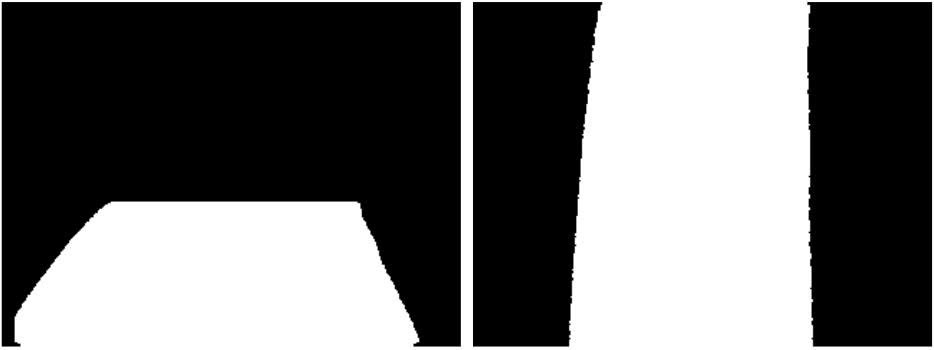

In [ ]:
# TODO: Define source and destination ratios (normalized coordinates)
# Hint: enter 4 ratio points in the form (x_ratio, y_ratio)
SRC_RATIOS = np.float32([... , ... , ... , ...])     # e.g.: (0.20, 0.58)

DST_RATIOS = np.float32([... , ... , ... , ...])     # e.g.: (0.25, 0.00)


# TODO: Compute pixel coordinates from ratios
# Hint: use mask01.shape to obtain H, W
H, W = ...


# Hint: multiply SRC_RATIOS and DST_RATIOS by [W, H] to convert to pixel coordinates
src_pts = ... * np.array([W, H], dtype=np.float32)
dst_pts = ... * np.array([W, H], dtype=np.float32)


# TODO: Compute the perspective transform matrix (homography)
M = cv2.getPerspectiveTransform(... , ...)


### Map the mask to BEV space

After computing the homography matrix \(M\), we can “flatten” the mask from the perspective image into the bird’s-eye-view (BEV) space using the function:  
cv2.warpPerspective(...)


In [ ]:
# TODO: Thực hiện biến đổi mask sang không gian BEV
bev = ...

# TODO: Chuyển kết quả warp về dạng mask nhị phân (0/1)
bev_mask = ...


### **Task 4 – Visualize the BEV result**

Display the original (refined) mask and the mask after BEV transformation side by side using Matplotlib.  
This helps you verify whether the transformation is correct and whether the lane region has been accurately projected into the BEV rectangle.


In [ ]:
plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.title('Mask sau refine')
plt.imshow(mask01, cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Mask BEV')
plt.imshow(bev_mask, cmap='gray')
plt.axis('off')

plt.show()
